In [293]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm import tqdm
import time
import copy
import seaborn as sns
import pandas as pd

In [294]:
# Environment module
class Environment:
    def __init__(self, pick_up, drop_off):
        # Generate initital random location for 'Female' agent
        x, y, z = np.random.randint(1,4), np.random.randint(1,4), np.random.randint(1,4)
        
        # Generate initial random location for 'Male' agent
        x_p, y_p, z_p = np.random.randint(1,4), np.random.randint(1,4), np.random.randint(1,4)
        # make sure the location is available
        while x_p == x and y_p == y and z_p == z:
            x_p, y_p, z_p = np.random.randint(1,4), np.random.randint(1,4), np.random.randint(1,4)
            
        # Define the shape of the environment (i.e., its states)
        self.states = (x, y, z, x_p, y_p, z_p, 0, 0, 0, 0, 0, 0, 10, 10)
        
        # Pick up and drop off locations
        self.pick_up = pick_up
        self.drop_off = drop_off
    
    def reset(self, pick_up, drop_off):
        self.__init__(pick_up, drop_off)
        female_agent_state, male_agent_state = StateRepresentation().preprocess(self.states)
        return female_agent_state, male_agent_state
    
    def is_terminal_state(self, state):
    # Determine if a state is a terminal state
        return state[6] == 0 and state[7] == 0 and state[8] == 5 and state[9] == 5 and state[10] == 5 \
            and state[11] == 5 and state[12] == 0 and state[13] == 0
    
    def update(self, agent_state, action, isFemale):
        # Extract variables
        x, y, z, x_p, y_p, z_p, i, i_p, a, b, c, d, e, f = self.states
        
        # Update the environment after the agent chose an action
        xx, yy, zz, ii = agent_state[0], agent_state[1], agent_state[2], agent_state[3]
        
        pickup_list = [e, f]
        dropoff_list = [a, b, c, d]
        
        # Decrease number of pick up at a specific location
        if ActionSpace().actions[action] == 'pickup':
            for j in range(len(pickup_list)):
                if self.pick_up[j][0] == (xx, yy, zz):
                    self.pick_up[j][1] -= 1
                    pickup_list[j] = self.pick_up[j][1]
                    break
                
        # Decrease number of drop off at a specific location
        elif ActionSpace().actions[action] == 'dropoff':
            for j in range(len(dropoff_list)):
                if self.drop_off[j][0] == (xx, yy, zz):
                    self.drop_off[j][1] += 1
                    dropoff_list[j] = self.drop_off[j][1]
                    break
        
        e, f = pickup_list[0], pickup_list[1]
        a, b, c, d = dropoff_list[0], dropoff_list[1], dropoff_list[2], dropoff_list[3]
        
        # if female agent takes action
        if isFemale:
            x, y, z, i = xx, yy, zz, ii
        # if male agent takes action
        else:
            x_p, y_p, z_p, i_p = xx, yy, zz, ii
            
        # update new state
        self.states = (x, y, z, x_p, y_p, z_p, i, i_p, a, b, c, d, e, f)
    
        # check if new state is terminal state
        done = self.is_terminal_state(self.states)
        
        # convert from world state to agents' state
        female_agent_state, male_agent_state = StateRepresentation().preprocess(self.states)
        
        return done, female_agent_state, male_agent_state

In [295]:
# Agent module
class Agent:
    def __init__(self, state, algorithm, policy, alpha, gamma):
        self.q_table = ValueFunction(alpha, gamma)
        self.algorithm = algorithm
        self.state = state
        self.policy = policy
        self.reward = 0
        self.pickup_state_count = 0
        self.dropoff_state_count = 0
        self.risky_state_count = 0
        
    def choose_action(self, environment, agent_state, other_agent_state):
        possible_actions = ActionSpace().get_possible_actions(environment, agent_state, other_agent_state)
        action = self.policy(self.q_table, agent_state, possible_actions)
        return action
    
    def take_action(self, environment, action, other_agent_state):
    

#         print("Agent picking action: ", ActionSpace().actions[action])
        
        # Determine next state and reward if the agent take the action from its current state
        new_state, reward = Model().predict(self, environment.states, action)
        
        # Q-Learning algorithm
        if self.algorithm == "QLEARNING":
            self.q_table.QLEARNING(self.state, action, new_state, reward)
            
        # SARSA algorithm
        elif self.algorithm == "SARSA":
            new_action = self.choose_action(environment, new_state, other_agent_state)
            self.q_table.SARSA(self.state, action, new_state, new_action, reward)
        
        # move to new state
        self.state = new_state
        
        # add reward
        self.reward += reward

In [296]:
# State representation module
class StateRepresentation:
    def preprocess(self, state):
        # Convert the state into a format that can be used by the agent
        (x, y, z, x_p, y_p, z_p, i, i_p, a, b, c, d, e, f) = state
        
        # Convert into female agent state
        if i == 0:
            s, t, u, v = state[12] >= 1, state[13] >= 1, False, False
        else:
            s, t, u, v = state[8] < 5, state[9] < 5, state[10] < 5, state[11] < 5
         
        female_agent_state = (x, y, z, i, s, t, u, v)
        
        # Convert into male agent state
        if i_p == 0:
            s, t, u, v = state[12] >= 1, state[13] >= 1, False, False
        else:
            s, t, u, v = state[8] < 5, state[9] < 5, state[10] < 5, state[11] < 5
         
        male_agent_state = (x_p, y_p, z_p, i_p, s, t, u, v)
            
        return female_agent_state, male_agent_state

In [297]:
# Action space module
class ActionSpace:
    def __init__(self):
        # Initialize the action space with the possible actions
        self.actions = ['north', 'east', 'south', 'west', 'up', 'down', 'pickup', 'dropoff']
    
    # Check if action 'pick up' is applicable given an agent state
    def CheckPickUp(self, pick_up, agent_state):
        # Extract variables
        x, y, z, i = agent_state[0], agent_state[1], agent_state[2], agent_state[3]
        
        # check if pick up is applicable
        for locations in pick_up:
            if locations[0] == (x, y, z) and locations[1] > 0 and i == 0:
                return True
    
    # Check if action 'drop off' is applicable given an agent state
    def CheckDropOff(self, drop_off, agent_state):
        # Extract variables
        x, y, z, i = agent_state[0], agent_state[1], agent_state[2], agent_state[3]
        
        # check if drop off is applicable
        for locations in drop_off:
            if locations[0] == (x, y, z) and locations[1] < 5 and i == 1:
                return True
    
    # Return a list of possible actions given the agent state and other agent state (this also handle collision between agents)
    def get_possible_actions(self, environment, agent_state, other_agent_state):
        
        # Initiate all actions '0'
        possible_actions = np.zeros(8)
        
        # Extract agent's location and other agent's location
        x, y, z = agent_state[0], agent_state[1], agent_state[2]
        x_p, y_p, z_p = other_agent_state[0], other_agent_state[1], other_agent_state[2]
    
        # Check if agent can move north
        if agent_state[1] < 3 and (x, y+1, z) != (x_p, y_p, z_p):
            possible_actions[0] = 1
        # Check if agent can move east
        if agent_state[0] < 3 and (x+1, y, z) != (x_p, y_p, z_p):
            possible_actions[1] = 1
        # Check if agent can move south
        if agent_state[1] > 1 and (x, y-1, z) != (x_p, y_p, z_p):
            possible_actions[2] = 1    
        # Check if agent can move west
        if agent_state[0] > 1 and (x-1, y, z) != (x_p, y_p, z_p):
            possible_actions[3] = 1
        # Check if agent can move up
        if agent_state[2] < 3 and (x, y, z+1) != (x_p, y_p, z_p):
            possible_actions[4] = 1
        # Check if agent can move down
        if agent_state[2] > 1 and (x, y, z-1) != (x_p, y_p, z_p):
            possible_actions[5] = 1
        # Check if agent can pick up
        if self.CheckPickUp(environment.pick_up, agent_state):
            possible_actions[6] = 1
        # Check if agent can drop off
        if self.CheckDropOff(environment.drop_off, agent_state):
            possible_actions[7] = 1
        
        return possible_actions

In [298]:
# Reward function module
class RewardFunction:
    def __init__(self):
        # Define rewards for each state
        self.rewards = np.full((4, 4, 4), -1)
        self.rewards[3, 1, 1] = -2 # Risky state
        self.rewards[2, 2, 2] = -2 # Risky state

    # Calculate the reward based on an action that takes agent to the given state
    def calculate(self, state, action):
        
        # Agent's current location
        x, y, z = state[0], state[1], state[2]

        # Reward
        reward = -1
        
        # If action was 'pick up' or 'drop off'
        if action == 6 or action == 7:
            reward = 14
        # If action was moving agent
        else:
            reward = self.rewards[x, y, z]

        return reward

In [299]:
# Policy module
class Policy:
    def __init__(self):
        self.Actions = ActionSpace()
    
    def PRANDOM(self, q_table, agent_state, possible_actions):   
        
        # Check if either pick up or drop off is applicable
        if possible_actions[6] == 1:
            return 6
        elif possible_actions[7] == 1:
            return 7
        
        # choosing action randomly
        action = np.random.randint(6)
        while possible_actions[action] == 0:
            action = np.random.randint(6)
            
        return action   
    
    def PEXPLOIT(self, q_table, agent_state, possible_actions):        
        
        # Check if either pick up or drop off is applicable
        if possible_actions[6] == 1:
            return 6
        elif possible_actions[7] == 1:
            return 7
        
        # 85% choosing the optimal action (action with highest q-value)
        if np.random.random() < 0.85:
            maxq = -100

            for actions in range(6):
                if possible_actions[actions] == 1:
                    if q_table.get_value(agent_state, actions) > maxq:
                        maxq = q_table.get_value(agent_state, actions)
                        action = actions
                    elif q_table.get_value(agent_state, actions) == maxq:
                        action = action if np.random.randint(2) == 0 else actions
        else:
            # 15% choosing action randomly
            action = np.random.randint(6)
            while possible_actions[action] == 0:
                action = np.random.randint(6)
            
        return action   
    
    
    def PGREEDY(self, q_table, agent_state, possible_actions):
        
        # Check if either pick up or drop off is applicable
        if possible_actions[6] == 1:
            return 6
        elif possible_actions[7] == 1:
            return 7
        
        # choosing action with the highest q-value
        maxq = -100
        
        for actions in range(6):
            if possible_actions[actions] == 1:
                if q_table.get_value(agent_state, actions) > maxq:
                    maxq = q_table.get_value(agent_state, actions)
                    action = actions
                elif q_table.get_value(agent_state, actions) == maxq:
                    action = action if np.random.randint(2) == 0 else actions
                
        return action

In [300]:
# Value function module
class ValueFunction:
    def __init__(self, alpha, gamma):
        self.alpha = alpha
        self.gamma = gamma
        self.q_table = {}
        
        # Initiate q-table (dictionary with key is state, and value is list of 6 actions)
        # q_table[state][action] gives the actual q-value of a state-action pair
        for x in range(1, 4):
            for y in range(1, 4):
                for z in range(1, 4):
                    for i in range(0, 2):
                        for s in range(0, 2):
                            for t in range(0, 2):
                                for u in range(0, 2):
                                    for v in range(0, 2):
                                        self.q_table[(x, y, z, i, s, t, u, v)] = []
                                        for action in range(8):
                                            self.q_table[(x, y, z, i, s, t, u, v)].append(0)
                                            
    # Update Q-Table
    def QLEARNING(self, state, action, new_state, reward):
        self.q_table[state][action] = self.q_table[state][action] \
                                            + self.alpha*(reward + self.gamma*np.max(self.q_table[new_state]) \
                                            - self.q_table[state][action])
        
    def SARSA(self, state, action, new_state, new_action, reward):
        self.q_table[state][action] = self.q_table[state][action] \
                                            + self.alpha*(reward + self.gamma*self.q_table[new_state][new_action] \
                                            - self.q_table[state][action])
        
    # Get a specific Q-value in the Q-Table
    def get_value(self, state, action):
        return self.q_table[state][action]
        

In [301]:
# Model module
class Model:
    
    # Return next state and its reward given the agent current state, world state, and action performed by the agent
    def predict(self, agent, states, action):
        
        # Extract variables
        agent_state = agent.state
        x, y, z, i, s, t, u, v = agent_state[0], agent_state[1], agent_state[2], agent_state[3], agent_state[4], agent_state[5], agent_state[6], agent_state[7]
        
        # move north
        if ActionSpace().actions[action] == 'north' and y < 3:
            y = y + 1
        # move east
        elif ActionSpace().actions[action] == 'east' and x < 3:
            x = x + 1
        # move south
        elif ActionSpace().actions[action] == 'south' and y > 1:
            y = y - 1
        # move west
        elif ActionSpace().actions[action] == 'west' and x > 1:
            x = x - 1
        # move up
        elif ActionSpace().actions[action] == 'up' and z < 3:
            z = z + 1
        # move down
        elif ActionSpace().actions[action] == 'down' and z > 1:
            z = z - 1
        # pick up
        elif ActionSpace().actions[action] == 'pickup' and i == 0:
            i = 1
            agent.pickup_state_count += 1
        # drop off
        elif ActionSpace().actions[action] == 'dropoff' and i == 1:
            i = 0
            agent.dropoff_state_count += 1
        if i == 0:
            s = 1 if states[12] >= 1 else 0
            t = 1 if states[13] >= 1 else 0
            u = 0
            v = 0
            
        else:
            s = 1 if states[8] < 5 else 0
            t = 1 if states[9] < 5 else 0
            u = 1 if states[10] < 5 else 0
            v = 1 if states[11] < 5 else 0
        
        # new state
        next_state = (x, y, z, i, s, t, u, v)
        
        # reward
        reward = RewardFunction().calculate(next_state, action)
        
        return next_state, reward


In [302]:
# Algorithm module
class Algorithm:  
    def __init__(self):
        #Risky locations
        self.risky_locations = [(2, 2, 2), (3, 2, 1)]
        
        # Pick up and drop off locations
        self.pickup_locations = [[(2, 2, 1), 10], [(3, 3, 2), 10]]
        self.dropoff_locations = [[(1, 1, 2), 0], [(1, 1, 3), 0], [(3, 1, 1), 0], [(3, 2, 3), 0]]
        
    # Compute Manhattan distance between 2 agents given their states
    def compute_distance(self, agent_state, other_agent_state):
        # Extract locations
        x, y, z = agent_state[0], agent_state[1], agent_state[2]
        x_p, y_p, z_p = other_agent_state[0], other_agent_state[1], other_agent_state[2]
        
        # Compute distance
        distance = ((x-x_p)**2 + (y-y_p)**2 + (z-z_p)**2)**0.5
        return distance

    # Check if a state is a risky state
    def check_risky_state(self, state):
        # Extract locations
        state = (state[0], state[1], state[2])
        
        # Check risky state
        for location in self.risky_locations:
            if state == location:
                return True
            
        return False

In [303]:
# Training module
class Training: 
    def train(self, total_steps, alpha, gamma, algorithm1, algorithm2, policy1, policy2, flag=False):
        
        alg = Algorithm()
        
        # Initialize environment
        environment = Environment(copy.deepcopy(alg.pickup_locations), copy.deepcopy(alg.dropoff_locations))
        
        # Initiate 2 agents
        female_agent_state, male_agent_state = StateRepresentation().preprocess(environment.states)
        female_agent = Agent(female_agent_state, algorithm1, policy1, alpha, gamma)
        male_agent = Agent(male_agent_state, algorithm1, policy1, alpha, gamma)
        
        agent_coordination = []
        done = False
        terminal_state_count = 0
        
        # Start training
        for step in range(0, total_steps+1):
            #if step % 100 == 0:
                #print("Step [{}/{}]".format(step, total_steps))
        
            # Update algorithm and policy
            if step > 500:
                (female_agent.algorithm, female_agent.policy) = (algorithm2, policy2)
                (male_agent.algorithm, male_agent.policy) = (algorithm2, policy2)
                
            if step % 2 == 0:
                # Female's move
                action = female_agent.choose_action(environment, female_agent.state, male_agent.state)
                female_agent.take_action(environment, action, male_agent.state)
                
                # Check if the agent move into a risky state
                if alg.check_risky_state(female_agent.state):
                    female_agent.risky_state_count += 1
                
                # Update world state space
                done, female_agent.state, male_agent.state = environment.update(female_agent.state, action, True)
            else:
                # Male's move
                action = male_agent.choose_action(environment, male_agent.state, female_agent.state)
                male_agent.take_action(environment, action, female_agent.state)
                
                # Check if the agent move into a risky state
                if alg.check_risky_state(male_agent.state):
                    male_agent.risky_state_count += 1
                    
                # Update world state space
                done, female_agent.state, male_agent.state = environment.update(male_agent.state, action, False)
            
            # Compute distance
            agent_coordination.append(Algorithm().compute_distance(female_agent.state, male_agent.state))
            
            # Check for terminal state
            if done:
                terminal_state_count += 1
                  
                # Change pick up locations
                if flag:
                    if terminal_state_count == 3:
                        alg.pickup_locations = [[(2, 3, 3), 10], [(1, 3, 1), 10]]
                    elif terminal_state_count == 6:
                        break
                    
                # Reset the environment to initial state
                female_agent.state, male_agent.state = environment.reset(copy.deepcopy(alg.pickup_locations),
                                                                         copy.deepcopy(alg.dropoff_locations))
                    
        return Evaluation(female_agent, male_agent, agent_coordination, terminal_state_count)

In [304]:
# Evaluation module
class Evaluation:
    def __init__(self, female_agent, male_agent, agent_coordination, terminal_state_count):
        self.female_agent = female_agent
        self.male_agent = male_agent
        self.agent_coordination = agent_coordination
        self.terminal_state_count = terminal_state_count
    
    def _plot_(self, data, z):
        
        # Swap row 1 with row 3
        temp = data[1]
        data[1] = data[3]
        data[3] = temp
        
        # Define the data for the visualization
        num_states = 9
        num_actions = 8
        
        # Create a 3x3 grid of subplots
        fig, axs = plt.subplots(3, 3, figsize=(10, 8))

        colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
        # Iterate over each subplot and plot a bar chart of the corresponding data
        for i in range(num_states):
            row = i // 3
            col = i % 3
            axs[row, col].bar(range(8), data[row+1][col+1], color=colors)
            axs[row, col].set_ylim([0, num_actions])
            axs[row, col].set_xticks([])


        # Set a title for the entire grid
        fig.suptitle('Q-Values for state (*,*,{},0,1,1,0,0)'.format(z), fontsize=16)

        # Add a single x-axis label that spans the entire grid
        fig.add_subplot(111, frameon=False)
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        plt.xlabel('Actions', fontsize=14)

        # Add a single y-axis label that spans the entire grid
        fig.add_subplot(111, frameon=False)
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        plt.ylabel('Q-Value', fontsize=14, rotation=90)

        # Adjust the spacing
        fig.tight_layout(pad=2)

        # Create a legend for the colors
        legend_elements = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
        fig.legend(legend_elements, ['North', 'East', 'South', 'West', 'Up', 'Down', 'Pick up', 'Drop off'], loc='upper right')
        
        # Show the plot
        plt.show()
        
        
    def plot_q_table(self, agent):
        if agent == "male":
            agent = self.male_agent
        else:
            agent = self.female_agent
            
        # plot for z=1
        data = list(np.empty((4, 4, 8), dtype=object))
        for i in range(1, 4):
            for j in range(1, 4):
                    data[i][j] = agent.q_table.q_table[(i, j, 1, 0, 1, 1, 0, 0)]
        self._plot_(data=data, z=1)
            
        # plot for z=2
        data = list(np.empty((4, 4, 8), dtype=object))
        for i in range(1, 4):
            for j in range(1, 4):
                    data[i][j] = agent.q_table.q_table[(i, j, 2, 0, 1, 1, 0, 0)]
        self._plot_(data=data, z=2)    
        
        # plot for z=3
        data = list(np.empty((4, 4, 8), dtype=object))
        for i in range(1, 4):
            for j in range(1, 4):
                    data[i][j] = agent.q_table.q_table[(i, j, 3, 0, 1, 1, 0, 0)]
        self._plot_(data=data, z=3)

    def plot_distance(self, steps):
        distance_table = pd.DataFrame.from_dict( { 'Distance': self.agent_coordination } )
        distance_table = distance_table[:steps]
        distance_table['Steps'] = distance_table.index
        rcParams['figure.figsize'] = 30, 7
        plt.tight_layout()
        sns.lineplot(data=distance_table, x='Steps', y='Distance')
        plt.show()
        
    def print_result(self):
        print("Total terminal states reached:", results.terminal_state_count)
        print()
        print('---Agent male summary---')
        print("Average reward:", results.male_agent.reward/results.terminal_state_count)
        print("Average risky states reached:", results.male_agent.risky_state_count/results.terminal_state_count)
        print("Average pick up times: ", results.male_agent.pickup_state_count/results.terminal_state_count)
        print("Average drop off times: ", results.male_agent.dropoff_state_count/results.terminal_state_count)
        print()
        print('---Agent female summary---')
        print("Average reward:", results.female_agent.reward/results.terminal_state_count)
        print("Average risky states reached:", results.female_agent.risky_state_count/results.terminal_state_count)
        print("Average pick up times: ", results.female_agent.pickup_state_count/results.terminal_state_count)
        print("Average drop off times: ", results.female_agent.dropoff_state_count/results.terminal_state_count)

In [305]:
# Experiment 1a
TrainedModel = Training()
results = TrainedModel.train(10000, 0.3, 0.5, "QLEARNING", "QLEARNING", Policy().PRANDOM, Policy().PRANDOM, flag=False)

In [306]:
results.print_result()

Total terminal states reached: 11

---Agent male summary---
Average reward: -196.8181818181818
Average risky states reached: 38.09090909090909
Average pick up times:  9.727272727272727
Average drop off times:  9.636363636363637

---Agent female summary---
Average reward: -171.45454545454547
Average risky states reached: 39.18181818181818
Average pick up times:  10.636363636363637
Average drop off times:  10.545454545454545


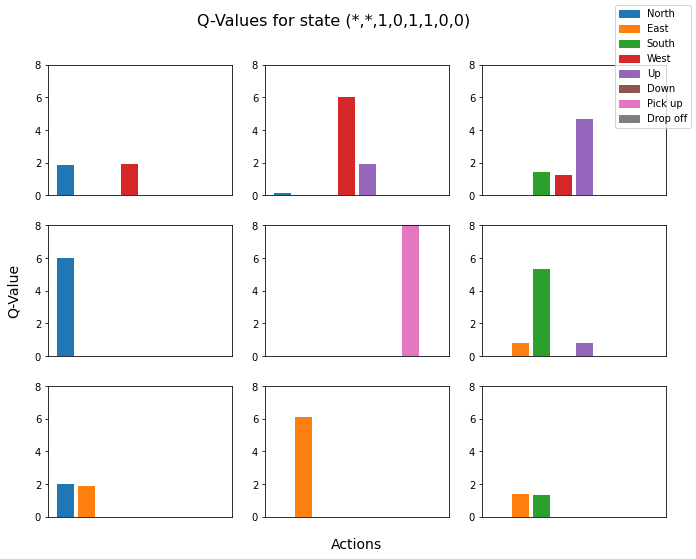

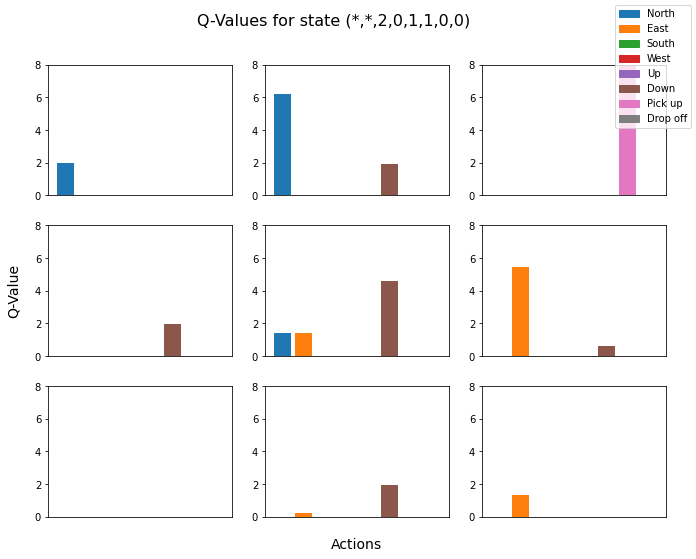

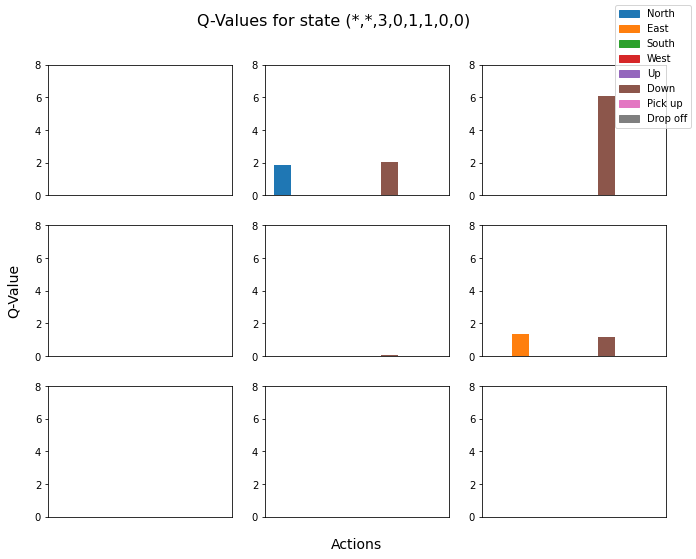

In [307]:
results.plot_q_table("female")

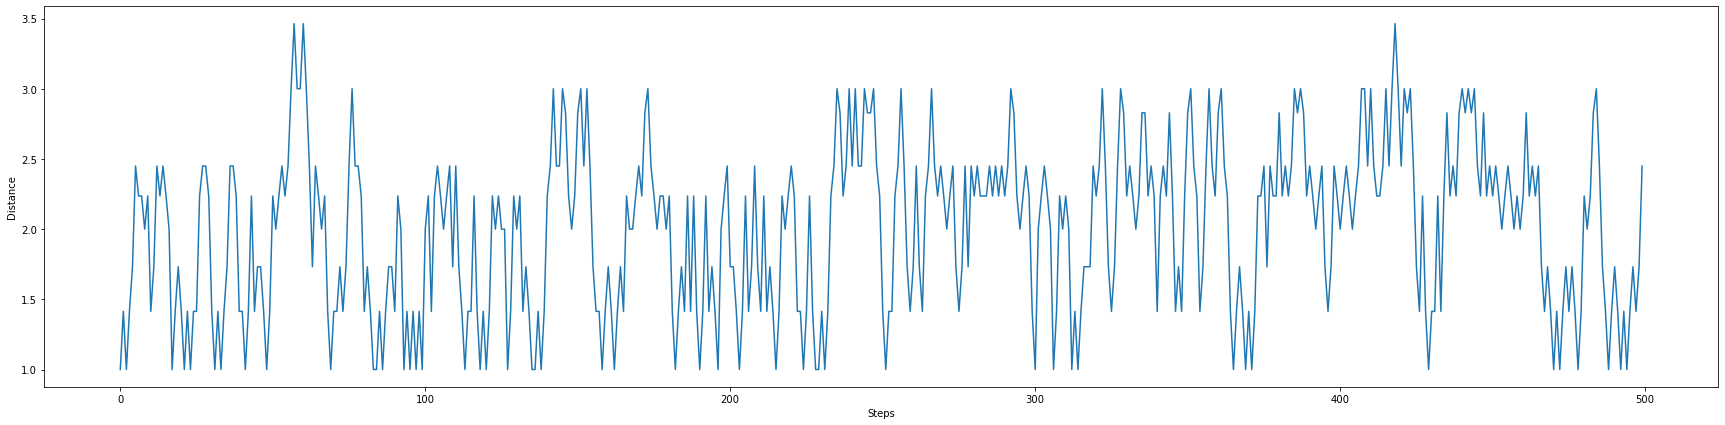

In [321]:
results.plot_distance(500)

In [309]:
# Experiment 1b
TrainedModel = Training()
results = TrainedModel.train(10000, 0.3, 0.5, "QLEARNING", "QLEARNING", Policy().PRANDOM, Policy().PGREEDY, flag=False)

In [310]:
results.print_result()

Total terminal states reached: 39

---Agent male summary---
Average reward: 166.92307692307693
Average risky states reached: 4.512820512820513
Average pick up times:  10.025641025641026
Average drop off times:  10.0

---Agent female summary---
Average reward: 174.12820512820514
Average risky states reached: 6.6923076923076925
Average pick up times:  10.23076923076923
Average drop off times:  10.23076923076923


In [311]:
# Experiment 1c
TrainedModel = Training()
results = TrainedModel.train(10000, 0.3, 0.5, "QLEARNING", "QLEARNING", Policy().PRANDOM, Policy().PEXPLOIT, flag=False)

In [312]:
results.print_result()

Total terminal states reached: 35

---Agent male summary---
Average reward: 162.74285714285713
Average risky states reached: 6.914285714285715
Average pick up times:  10.428571428571429
Average drop off times:  10.428571428571429

---Agent female summary---
Average reward: 149.71428571428572
Average risky states reached: 7.257142857142857
Average pick up times:  9.942857142857143
Average drop off times:  9.914285714285715


In [313]:
# Experiment 2
TrainedModel = Training()
results = TrainedModel.train(10000, 0.3, 0.5, "QLEARNING", "SARSA", Policy().PRANDOM, Policy().PEXPLOIT, flag=False)

In [314]:
results.print_result()

Total terminal states reached: 36

---Agent male summary---
Average reward: 165.69444444444446
Average risky states reached: 8.444444444444445
Average pick up times:  10.38888888888889
Average drop off times:  10.38888888888889

---Agent female summary---
Average reward: 159.88888888888889
Average risky states reached: 7.333333333333333
Average pick up times:  10.166666666666666
Average drop off times:  10.13888888888889


In [315]:
# Experiment 3a
TrainedModel = Training()
results = TrainedModel.train(10000, 0.1, 0.5, "QLEARNING", "SARSA", Policy().PRANDOM, Policy().PEXPLOIT, flag=False)

In [316]:
results.print_result()

Total terminal states reached: 27

---Agent male summary---
Average reward: 112.5925925925926
Average risky states reached: 12.481481481481481
Average pick up times:  10.25925925925926
Average drop off times:  10.222222222222221

---Agent female summary---
Average reward: 114.88888888888889
Average risky states reached: 12.25925925925926
Average pick up times:  10.333333333333334
Average drop off times:  10.296296296296296


In [317]:
# Experiment 3b
TrainedModel = Training()
results = TrainedModel.train(10000, 0.5, 0.5, "QLEARNING", "SARSA", Policy().PRANDOM, Policy().PEXPLOIT, flag=False)

In [318]:
results.print_result()

Total terminal states reached: 39

---Agent male summary---
Average reward: 163.74358974358975
Average risky states reached: 6.487179487179487
Average pick up times:  9.923076923076923
Average drop off times:  9.897435897435898

---Agent female summary---
Average reward: 181.43589743589743
Average risky states reached: 10.538461538461538
Average pick up times:  10.564102564102564
Average drop off times:  10.538461538461538


In [319]:
# Experiment 4
TrainedModel = Training()
results = TrainedModel.train(10000, 0.3, 0.5, "QLEARNING", "SARSA", Policy().PRANDOM, Policy().PEXPLOIT, flag=True)

In [320]:
results.print_result()

Total terminal states reached: 6

---Agent male summary---
Average reward: -32.833333333333336
Average risky states reached: 21.166666666666668
Average pick up times:  9.333333333333334
Average drop off times:  9.333333333333334

---Agent female summary---
Average reward: 6.0
Average risky states reached: 23.833333333333332
Average pick up times:  10.666666666666666
Average drop off times:  10.666666666666666
